Используйте базу трафика с сайта компании. 

Напишите модель для прогнозирования трафика. 

При параметре `length = 60`, добейтесь максимально точного соответствия между графиками корреляции исходного сигнала и прогноза.

In [ ]:
import numpy as np      # Работа с массивами
import pandas as pd     # Работа с таблицами
import gdown            # Загрузка датасетов из облака google

# Кодирование категориальных данных в формате OHE
from tensorflow.keras.utils import to_categorical

# Генератор выборки временных рядов
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Нормировщики
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt  # Отрисовка графиков
import plotly.express as px 
%matplotlib inline               

import warnings                  # Отключение предупреждений
warnings.filterwarnings('ignore')

## Open dataset

In [ ]:
#Загружаем базу трафика с сайта компании
gdown.download('https://storage.googleapis.com/datasets_ai/Base/11_timeseries/traff.csv', None, quiet=True)

'traff.csv'

In [ ]:
# read datase 
data = pd.read_csv('traff.csv', names=['date', 'traffic'],
                   parse_dates=True, index_col='date')

# get rid of a decimal separator
data['traffic'] = data['traffic'].str.replace(',', '').astype(float)
#data.drop('date', axis=1, inplace=True)

## Observe the dataset

In [ ]:
data.head()

,traffic
date,
2017-01-01,22226.0
2017-01-02,29593.0
2017-01-03,31726.0
2017-01-04,32684.0
2017-01-05,31820.0


In [ ]:
data.shape

(1095, 1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1095 entries, 2017-01-01 to 2019-12-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   traffic  1095 non-null   float64
dtypes: float64(1)
memory usage: 17.1 KB


In [ ]:
fig = px.line(data, x=data.index, y=data.traffic)

# Show plot 
fig.show()

### Decompose time-series

By looking at the above plots we can see that our time-series is additive time-series and has both trend as well as seasonality. 

We can see the trend as traffic are increasing over time.

We can see seasonality with the same variations repeating for 1 year where value peaks somewhere around January

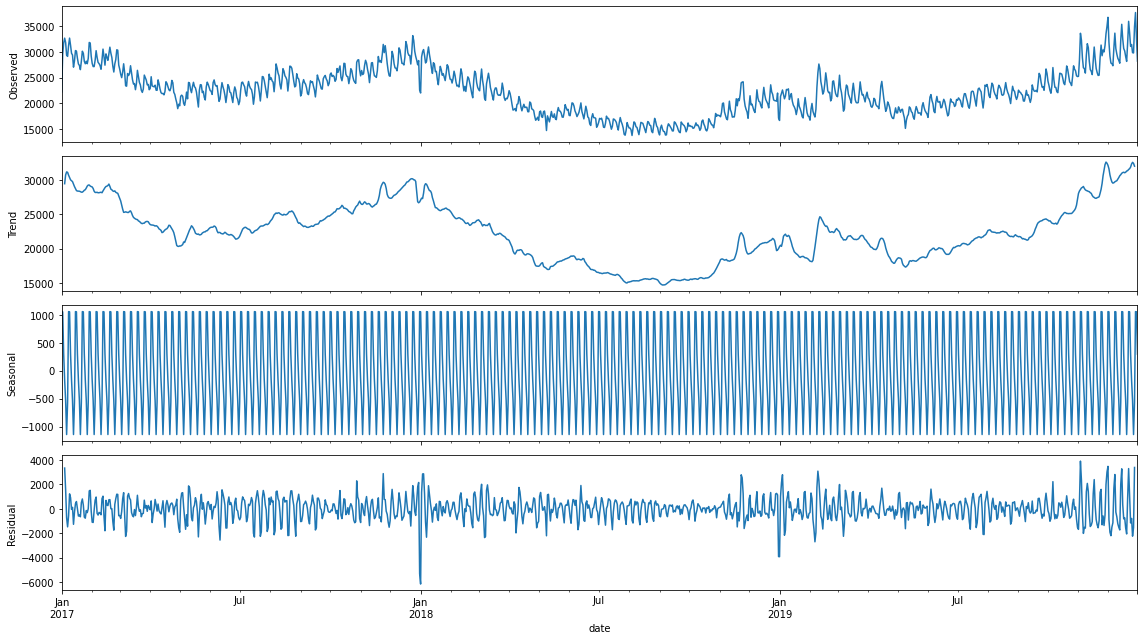

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(data, model="additive") #"multiplicative"

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid


fig = decompose_result.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show()

### Checking Whether Time-Series is Stationary or Not

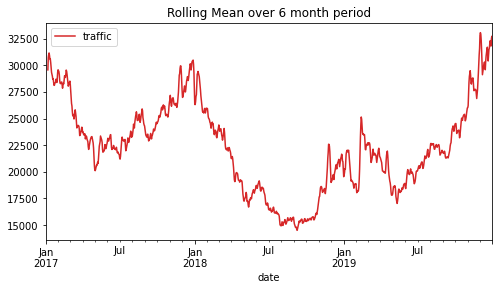

In [ ]:
data.rolling(window = 6).mean().plot(figsize=(8,4),
                                      color="tab:red",
                                      title="Rolling Mean over 6 month period");

We can see the strong seasonality effect


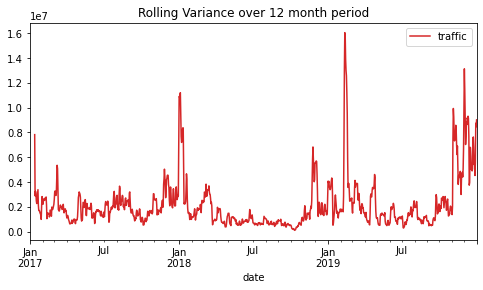

In [ ]:
data.rolling(window = 12).var().plot(figsize=(8,4),
                                     color="tab:red",
                                     title="Rolling Variance over 12 month period")

Below we are also plotting auto-correlation plot for time-series data as well. This plot helps us understand whether present values of time-series are positively correlated, negatively correlated or not related at all with past values. We can notice that the line doesnt cross the confidence interval (light blue area). So we can say that there is no autocorrelation between data

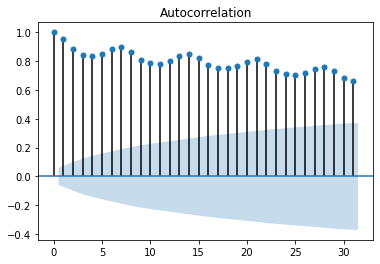

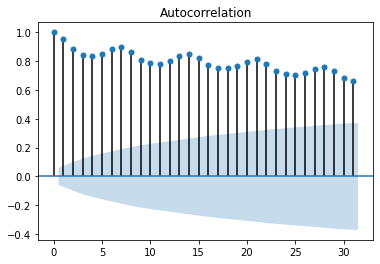

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(data)

### Testing with Dicky-Fuller

In [ ]:
from statsmodels.tsa.stattools import adfuller

def dicky_test(column):
  dftest = adfuller(column, autolag = 'AIC')

  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)

dicky_test(data['traffic'])

1. ADF :  -1.2202838362522808
2. P-Value :  0.6648098250239314
3. Num Of Lags :  21
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1073
5. Critical Values :
	 1% :  -3.436459052172655
	 5% :  -2.864237372528562
	 10% :  -2.568206176974609


We can interpret above results based on p-values of result.

p-value > 0.05 - This implies that time-series is non-stationary.

p-value <=0.05 - This implies that time-series is stationary.

We can see from the above results that p-value is greater than 0.05 hence our time-series is not stationary. It still has time-dependent components present which we need to remove.

## Get rid of seasonal patern

In [ ]:
data_diff = data - data.shift()
data_diff = data_diff[~data_diff['traffic'].isna()]

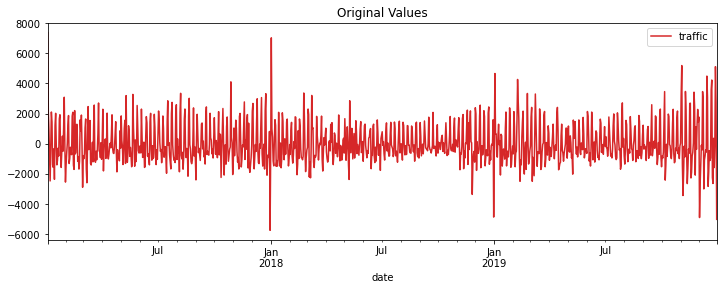

In [ ]:

data_diff.plot(figsize=(12,4),
               color="tab:red",
               title="Original Values");

In [ ]:
dicky_test(data_diff['traffic'])
#perfect

1. ADF :  -8.295237889828904
2. P-Value :  4.1572023137882793e-13
3. Num Of Lags :  20
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 1073
5. Critical Values :
	 1% :  -3.436459052172655
	 5% :  -2.864237372528562
	 10% :  -2.568206176974609


## Data preparation

In [ ]:
# Задание гиперпараметров
SEQ_LEN = 60                             # Длина прошедших данных для анализа
BATCH_SIZE = 20                           # Объем батча для генератора
TEST_LEN = 200                          # Объем тестовой выборки
TRAIN_LEN = data.shape[0] - TEST_LEN      # Объем обучающей выборки

In [ ]:
# Разделение данных на тренировочный и тестовый наборы
# 2*SEQ_LEN - для разрыва между тренировочными и тестовыми данными 
# варьируемый параметр, страховка от пересечения
x_data = data.index.to_numpy()
y_data = data['traffic'].values

x_data_train, x_data_test = x_data[:TRAIN_LEN], x_data[TRAIN_LEN + 2*SEQ_LEN:]
y_data_train, y_data_test = y_data[:TRAIN_LEN], y_data[TRAIN_LEN + 2*SEQ_LEN:]

#resape numpy array to make 2d array from that
x_data_train = x_data_train.reshape(-1, 1)
x_data_test = x_data_test.reshape(-1, 1)

y_data_train = y_data_train.reshape(-1, 1)
y_data_test = y_data_test.reshape(-1, 1)

# Масштабирование данных
x_scaler = MinMaxScaler(feature_range=(0,1))
x_scaler.fit(x_data_train)
x_data_train = x_scaler.transform(x_data_train)
x_data_test = x_scaler.transform(x_data_test)

# Масштабирование данных
y_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler.fit(y_data_train)
y_data_train = y_scaler.transform(y_data_train)
y_data_test = y_scaler.transform(y_data_test)

# Проверка формы данных
print(f'Train data: {x_data_train.shape}, {y_data_train.shape}')
print(f'Test  data: {x_data_test.shape}, {y_data_test.shape}')

Train data: (895, 1), (895, 1)
Test  data: (80, 1), (80, 1)


In [ ]:
# Создание генератора для обучения
train_datagen = TimeseriesGenerator(x_data_train, 
                                    y_data_train,
                                    length=SEQ_LEN,
                                    stride=1,
                                    sampling_rate=1,
                                    batch_size=BATCH_SIZE)

# Аналогичный генератор для валидации при обучении
val_datagen = TimeseriesGenerator(x_data_test, 
                                  y_data_test,
                                  length=SEQ_LEN,
                                  stride=1,
                                  sampling_rate=1,
                                  batch_size=BATCH_SIZE)

# Проверка формы выдаваемого генератором результата
print(f'Train batch x: {train_datagen[0][0].shape}, y: {train_datagen[0][1].shape}')

Train batch x: (20, 60, 1), y: (20, 1)


Не забудем про тестовую выборку. Также при помощи генератора сформируем окончательные тестовые выборки:

In [ ]:
# Генератор тестовой выборки, генерирует один батч на всю выборку
test_datagen = TimeseriesGenerator(x_data_test, 
                                   y_data_test,
                                   length=SEQ_LEN,
                                   stride=1,
                                   sampling_rate=1,
                                   batch_size=x_data_test.shape[0])

# Формирование тестовой выборки из генератора
x_test, y_test = test_datagen[0]

# Проверка формы тестовой выборки
print(f'Test x: {x_data_test.shape}, y: {y_data_test.shape}')

Test x: (80, 1), y: (80, 1)


## Сервисные функции

Опишем сервисные функции, которые упростят дальнейшие эксперименты с архитектурами НС:
- get_pred() – обученная модель. Предсказывает результат, который возвращается к ненормированным данным;
- correlate() – расчет коэффициента автокорреляции;
- show_predict() – построение графиков предсказания и верных ответов;
- show_corr() – построение графика автокорреляции;
- eval_net() – объединяет предыдущие функции и показывает результаты обучения сети;
- train_eval_net() – процесс обучения сети и вывод ее результатов. В обучении модели подаются не отдельные выборки, а сразу генераторы, так как они дают тот же результат, что и отдельные выборки. При этом уже нет необходимости прописывать размер батча обучения, поскольку он прописан в самом генераторе.

In [ ]:
 # Функция расчета результата прогнозирования сети (предсказания)
def get_pred(model,          # модель
             x_test, y_test, # тестовая выборка
             y_scaler):      # масштабирующий объект для y

    # Вычисление и деномализация предсказания
    y_pred_unscaled = y_scaler.inverse_transform(model.predict(x_test))

    # Денормализация верных ответов
    y_test_unscaled = y_scaler.inverse_transform(y_test)

    # Возврат результата предсказания и верные ответы в исходном масштабе
    return y_pred_unscaled, y_test_unscaled

In [ ]:
# Функция создания пробного генератора и вывода его результатов на экран
# На входе - имитация выборок x_train, y_train
def show_gen(x_train, y_train, length=10, batch_size=5):
    # Создание генератора TimeseriesGenerator
    gen = TimeseriesGenerator(x_train,
                              y_train,
                              length=length,
                              sampling_rate=1,
                              stride=1,
                              batch_size=batch_size
                             )
    
    # Прохождение по элементам генератора (батчам) в цикле и вывод каждого батча
    for i, g in enumerate(gen):
        print('Батч №', i)
        print('x_train:\n', g[0])
        print('y_train:\n', g[1])
        print()   

In [ ]:
# Функция расчета корреляционного коэффициента Пирсона для двух рядов

def correlate(a, b):
    return np.corrcoef(a, b)[0, 1]

In [ ]:
# Функция визуализации результата предсказания сети и верных ответов
def show_predict(y_pred, y_true, # прогноз данных и исходный ряд
                 start, # точка ряда, с которой начинается отрисовка графика
                 length, # количество точек для отрисовки графика
                 chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
                 chn_names=['traffic'], # список имен каналов данных
                 title=''):

    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    # Построение графика по всем каналам данных
    plt.figure(figsize=(22, 6))
    
    for chn in chn_list:
        plt.plot(y_pred[start:start + length, chn],
                label=f'{chn_names[chn]} Прогноз')
        plt.plot(y_true[start:start + length, chn], 
                label=f'{chn_names[chn]} Базовый')

    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Данные')
    plt.legend()
    plt.show()

In [ ]:
# Функция рисования корреляций прогнозного ряда и исходного со смещением
def show_corr(y_pred, y_true, # прогноз данных и исходный ряд
              back_steps_max=10, # максимальное количество шагов смещения назад по времени
              chn_list=None, # список каналов данных для отрисовки (по умолчанию все)
              chn_names=['traffic'], 
              title=''): # список имен каналов данных
  
    # Если список каналов пуст - отображаются все каналы
    if not chn_list:
        chn_list = list(range(y_true.shape[1]))

    y_len = y_true.shape[0]
    steps = range(0, back_steps_max + 1)

    # Построение графика по всем каналам данных
    plt.figure(figsize=(14, 7))

    for chn in chn_list:
        # Вычисление коэффициентов корреляции базового ряда и предсказания с разным смещением
        cross_corr = [correlate(y_true[:y_len - step, chn], y_pred[step:, chn]) for step in steps]
        # Вычисление коэффициентов автокорреляции базового ряда с разным смещением
        auto_corr = [correlate(y_true[:y_len - step, chn], y_true[step:, chn]) for step in steps]

        plt.plot(cross_corr, label=f'{chn_names[chn]} Прогноз')
        plt.plot(auto_corr, label=f'{chn_names[chn]} Эталон')

    plt.title(title)
    
    # Назначение меток шкалы оси x
    plt.xticks(steps)
    plt.xlabel('Шаги смещения')
    plt.ylabel('Коэффициент корреляции')
    plt.legend()
    plt.show()

In [ ]:
# Функция визуализации результата работы сети
def eval_net(model, # модель
             x_test, y_test, # тестовая выборка
             y_scaler, # нормировщик выхода
             start=0, length=500, back_steps_max=20, # параметры отображения графиков
             title=''):
  
    # Получение денормализованного предсказания и данных базового ряда
    y_pred, y_true = get_pred(model, x_test, y_test, y_scaler)
    
    # Отрисовка графика сопоставления базового и прогнозного рядов
    # Прогнозный ряд сдвигается на 1 шаг назад, так как предсказание делалось на 1 шаг вперед 
    show_predict(y_pred[1:], y_true[:-1], start, length, 
                 title=f'{title}: Сопоставление базового и прогнозного рядов')
    # Отрисовка графика корреляционных коэффициентов до заданного максимума шагов смещения
    show_corr(y_pred, y_true, back_steps_max=back_steps_max, 
              title=f'{title}: Корреляционные коэффициенты по шагам смещения')

In [ ]:
# Функция обучения модели и отрисовки прогресса и оценки результатов 

def train_eval_net(model, # модель
                   train_datagen, val_datagen, # генераторы обучающей и проверочной выборок
                   epoch_list, # список эпох в виде [(epochs1, opt1), (epochs2, opt2), ...]
                   x_test, y_test, 
                   y_scaler, 
                   start=0, 
                   length=500, 
                   back_steps_max=20, 
                   title=''):
  
    # Отображение сводки модели
    model.summary()

    # Обучение модели в несколько фаз в соответствии со списком epoch_list
    for epochs, opt in epoch_list:
        # Компиляция модели
        model.compile(loss='mse', optimizer=opt)
        # Фаза обучения модели
        print(f'Обучение {epochs} эпох')
        history = model.fit(train_datagen, 
                            epochs=epochs, 
                            validation_data=val_datagen,
                            verbose=1)

        # Рисование графиков прошедшей фазы обучения
        fig = plt.figure(figsize=(14, 7))
        plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
        plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
        plt.title(f'{title}: График прогресса обучения')
        # Указание показывать только целые метки шкалы оси x
        fig.gca().xaxis.get_major_locator().set_params(integer=True)
        plt.xlabel('Эпоха обучения')
        plt.ylabel('Средняя ошибка')
        plt.legend()
        plt.show()

        # Рисование графиков оценки результата работы модели после фазы обучения
        eval_net(model, x_test, y_test, y_scaler, start=start, 
                 length=length, back_steps_max=back_steps_max, title=title)

## Обучение

## Вариант 1

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 56, 50)            300       
                                                                 
 flatten_6 (Flatten)         (None, 2800)              0         
                                                                 
 dense_12 (Dense)            (None, 10)                28010     
                                                                 
 dense_13 (Dense)            (None, 1)                 11        
                                                                 
Total params: 28,321
Trainable params: 28,321
Non-trainable params: 0
_________________________________________________________________
Обучение 20 эпох
Epoch 1/20
42/42 [==============================] - 1s 6ms/step - loss: 0.1217 - val_loss: 0.2875
Epoch 2/20
42/42 [==============================] - 0s 5ms/step - l

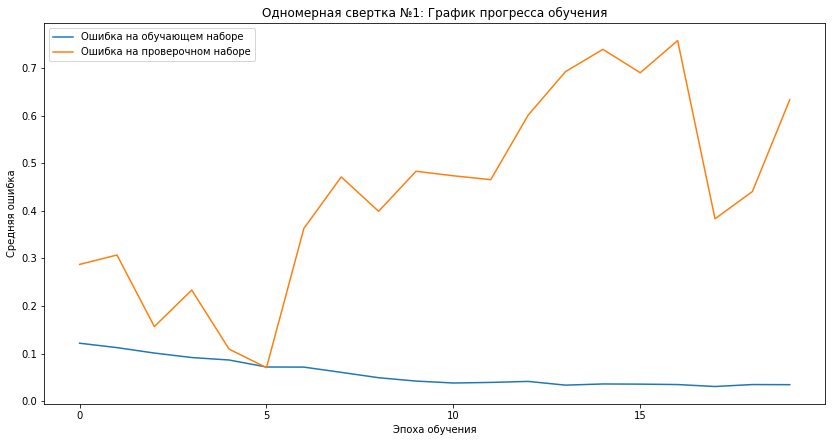

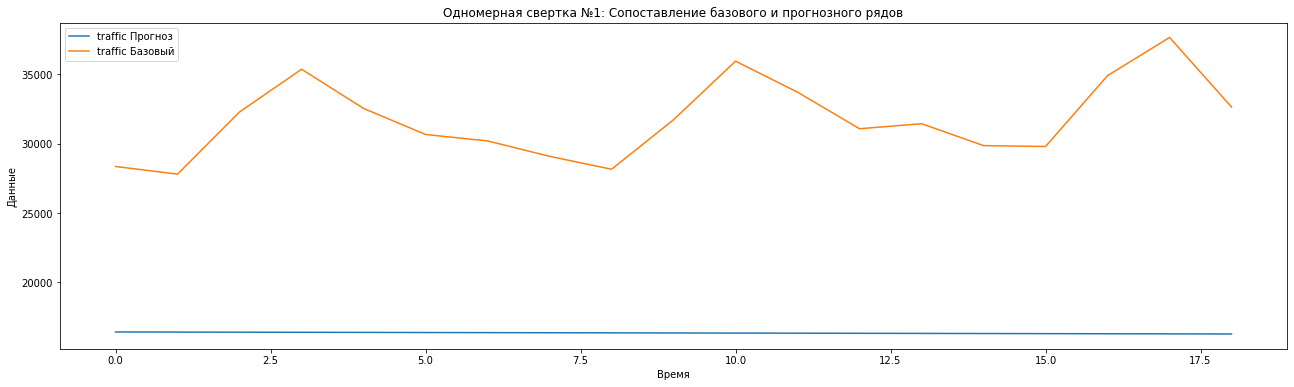

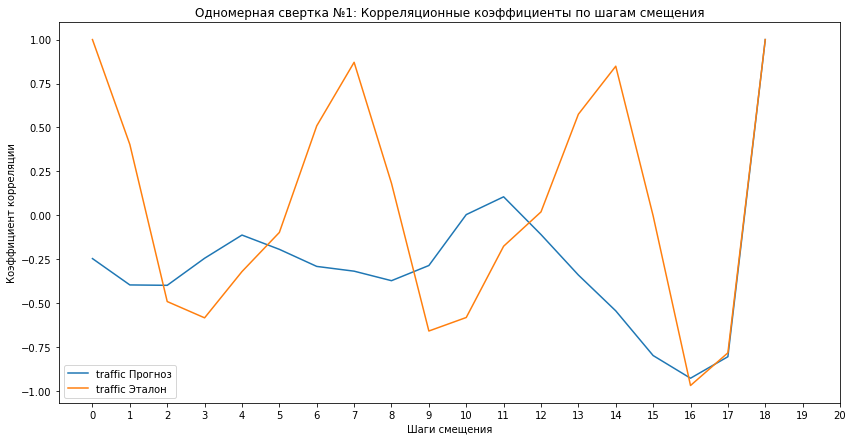

Обучение 20 эпох
Epoch 1/20
42/42 [==============================] - 1s 8ms/step - loss: 0.0304 - val_loss: 0.6334
Epoch 2/20
42/42 [==============================] - 0s 4ms/step - loss: 0.0307 - val_loss: 0.6342
Epoch 3/20
42/42 [==============================] - 0s 5ms/step - loss: 0.0305 - val_loss: 0.6590
Epoch 4/20
42/42 [==============================] - 0s 5ms/step - loss: 0.0302 - val_loss: 0.6301
Epoch 5/20
42/42 [==============================] - 0s 4ms/step - loss: 0.0305 - val_loss: 0.6302
Epoch 6/20
42/42 [==============================] - 0s 4ms/step - loss: 0.0309 - val_loss: 0.6293
Epoch 7/20
42/42 [==============================] - 0s 4ms/step - loss: 0.0307 - val_loss: 0.5970
Epoch 8/20
42/42 [==============================] - 0s 5ms/step - loss: 0.0303 - val_loss: 0.6337
Epoch 9/20
42/42 [==============================] - 0s 4ms/step - loss: 0.0304 - val_loss: 0.6592
Epoch 10/20
42/42 [==============================] - 0s 5ms/step - loss: 0.0306 - val_loss: 0.6460
Ep

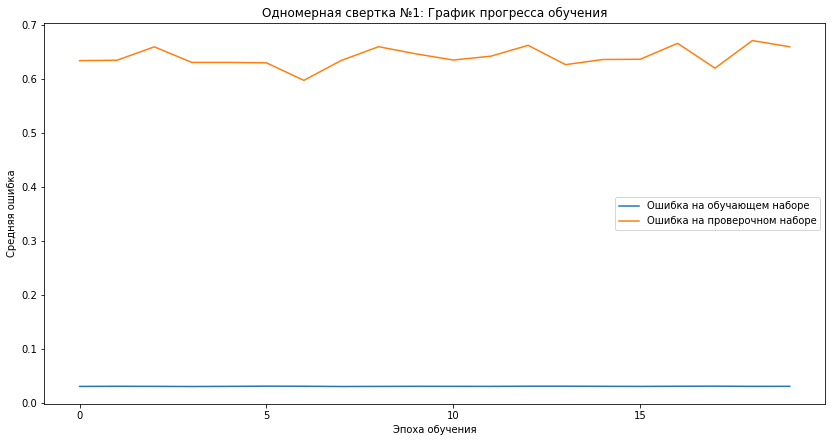

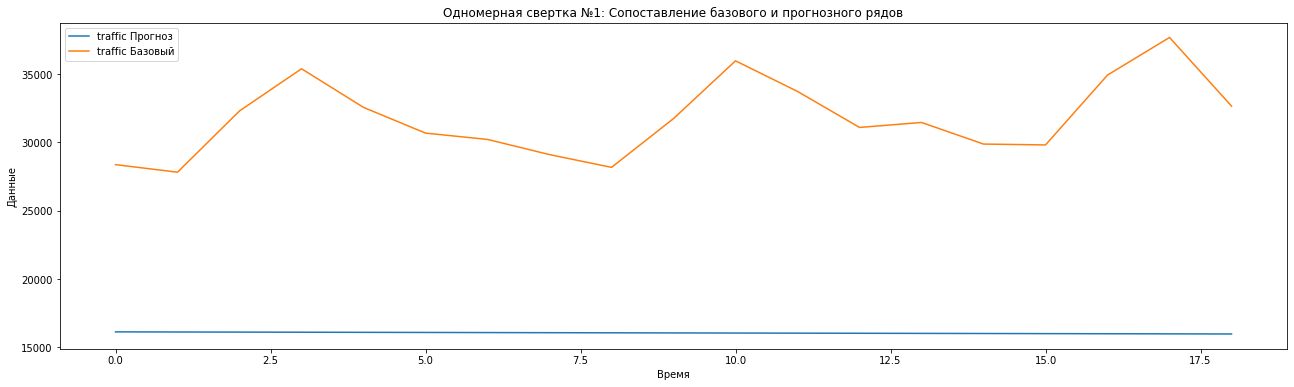

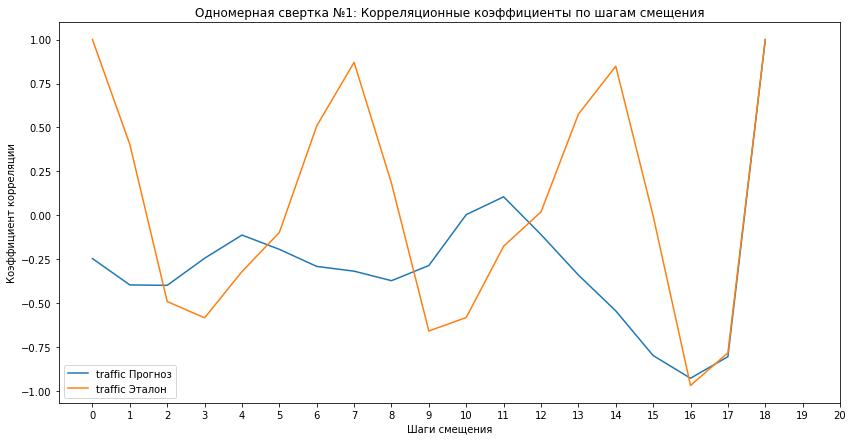

In [ ]:
# Упрощенная модель с одномерной сверткой
model_conv_1 = Sequential()
model_conv_1.add(Conv1D(50, 5,
                        input_shape=x_test.shape[1:],
                        activation='linear'))
model_conv_1.add(Flatten())
model_conv_1.add(Dense(10, activation='linear'))
model_conv_1.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 2x20 эпох
train_eval_net(model_conv_1, 
               train_datagen,
               val_datagen, [(20, Adam(lr=1e-4)),
                             (20, Adam(lr=1e-5))],
               x_test, y_test, 
               y_scaler, 
               title='Одномерная свертка №1')

## Вариант 2

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 60)                0         
                                                                 
 dense_14 (Dense)            (None, 150)               9150      
                                                                 
 dense_15 (Dense)            (None, 1)                 151       
                                                                 
Total params: 9,301
Trainable params: 9,301
Non-trainable params: 0
_________________________________________________________________
Обучение 20 эпох
Epoch 1/20
42/42 [==============================] - 1s 6ms/step - loss: 0.1182 - val_loss: 0.2008
Epoch 2/20
42/42 [==============================] - 0s 3ms/step - loss: 0.1061 - val_loss: 0.1536
Epoch 3/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0992 - val_loss: 0.1621
Epoch

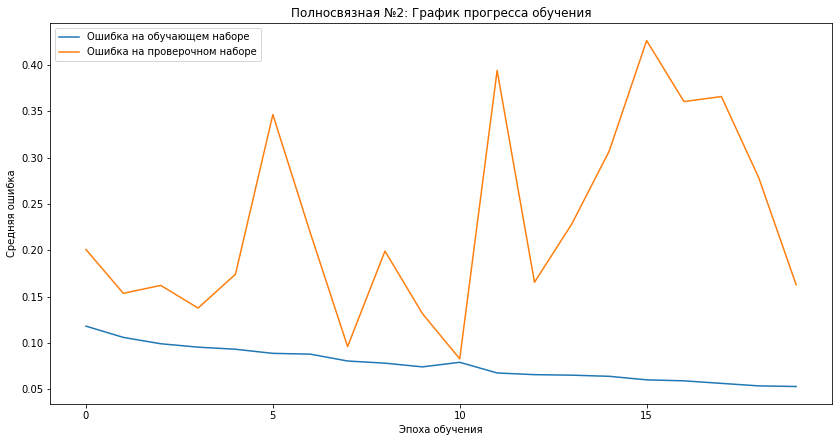

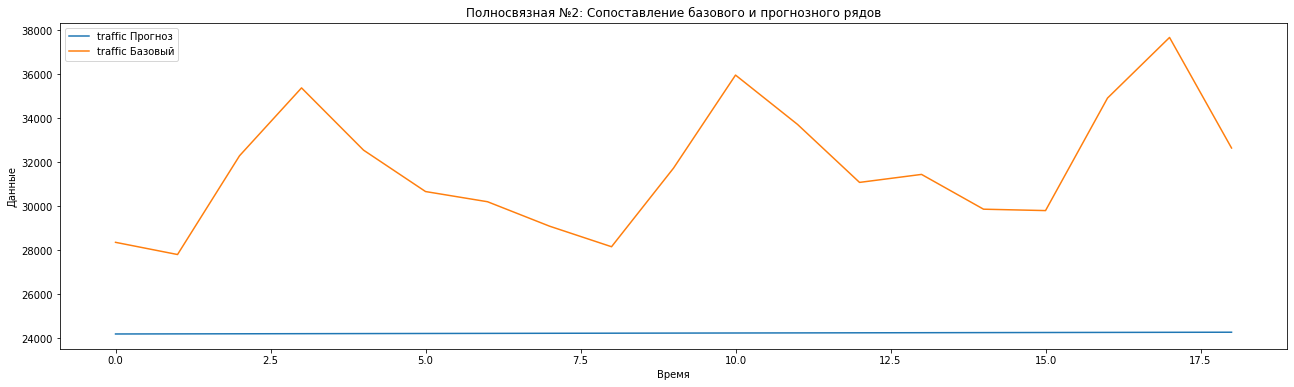

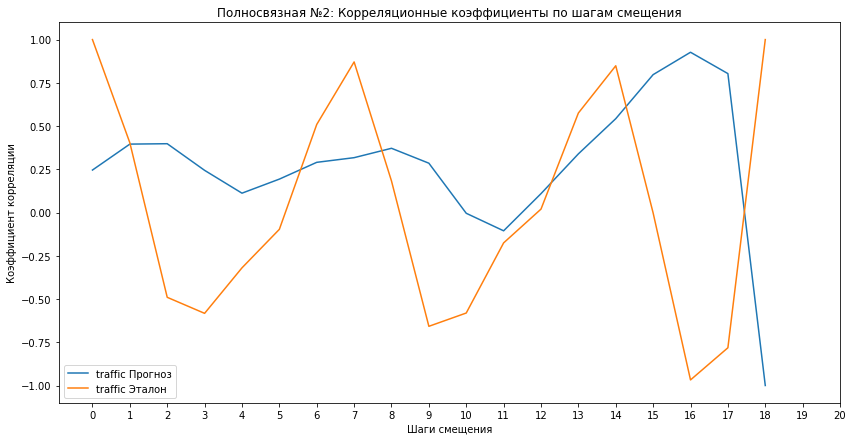

Обучение 20 эпох
Epoch 1/20
42/42 [==============================] - 1s 5ms/step - loss: 0.0555 - val_loss: 0.2128
Epoch 2/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0507 - val_loss: 0.2835
Epoch 3/20
42/42 [==============================] - 0s 4ms/step - loss: 0.0499 - val_loss: 0.3158
Epoch 4/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0497 - val_loss: 0.3229
Epoch 5/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0494 - val_loss: 0.3328
Epoch 6/20
42/42 [==============================] - 0s 4ms/step - loss: 0.0496 - val_loss: 0.3189
Epoch 7/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0495 - val_loss: 0.3305
Epoch 8/20
42/42 [==============================] - 0s 4ms/step - loss: 0.0493 - val_loss: 0.3409
Epoch 9/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0498 - val_loss: 0.3144
Epoch 10/20
42/42 [==============================] - 0s 3ms/step - loss: 0.0492 - val_loss: 0.3356
Ep

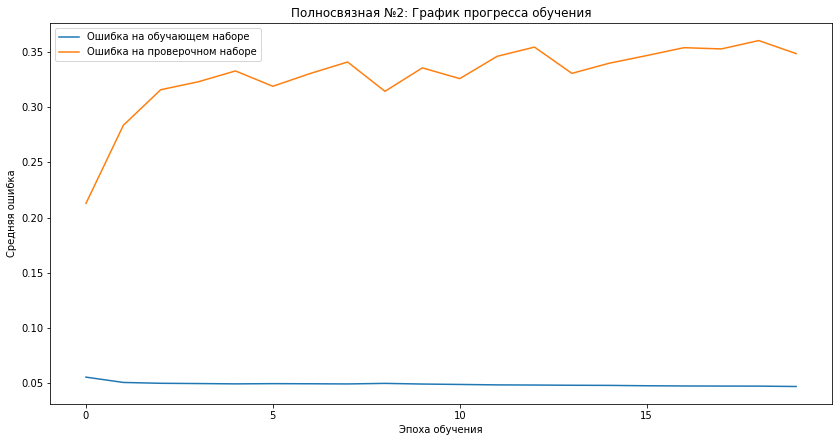

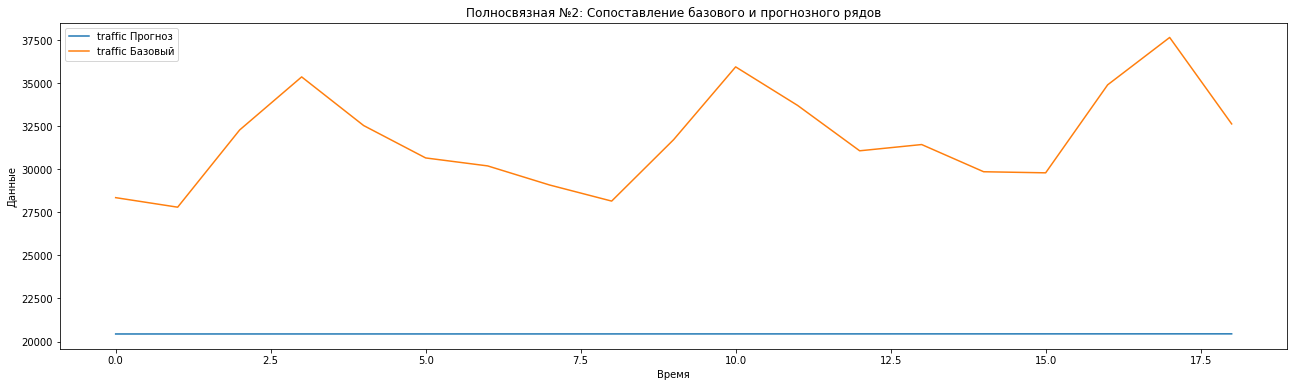

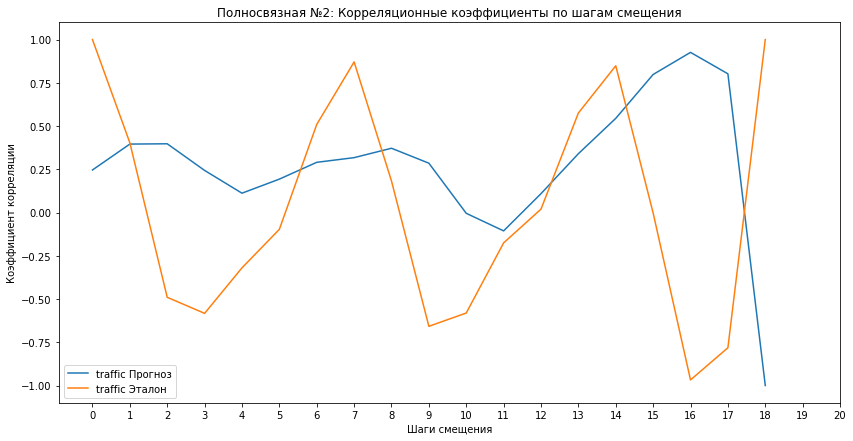

In [ ]:
# Полносвязная сеть с Flatten
model_dense_2 = Sequential()
model_dense_2.add(Flatten(input_shape=x_test.shape[1:]))
model_dense_2.add(Dense(150, activation='relu'))
model_dense_2.add(Dense(y_test.shape[1], activation='linear'))

# Обучение модели 2x20 эпох
train_eval_net(model_dense_2, 
               train_datagen,
               val_datagen, [(20, Adam(lr=1e-4)),
                             (20, Adam(lr=1e-5))],
               x_test, y_test, 
               y_scaler, title='Полносвязная №2')